## Influential people's tweets 

The idea of this part of project is to explore how influential people (politicians, journalists, singers, actors, etc.) from different countries used Twitter during the coronavirus pandemic. This task is meant to show how covid actually affected communication on a semantic level, by promoting hashtags and usage of certain words.

In [1]:
import pandas as pd
import numpy as np

import re
import json
import string
from datetime import datetime, timedelta

import translators as ts

# Natural language processing libraries
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Twitter library
import tweepy

#Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Importing hbbelper functions
from helpers import *

import warnings
warnings.filterwarnings('ignore')

Using state Vaud server backend.


<br/>
We are using intervention data (from the given dataset coronawiki) in order to define periods of interest to analyse tweets for each country.

In [2]:
# Importing intervention dates for each country
data_path = './data/'

interventions = pd.read_csv(data_path + 'interventions.csv', delimiter=',', 
                            parse_dates=['1st case', '1st death', 'School closure',
                                         'Public events banned', 'Lockdown', 'Mobility', 'Normalcy'])

interventions.set_index('lang', inplace=True)
interventions.head()

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
lang,,,,,,,
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaT,2020-03-16,2020-05-29


We are loading dataset which provides us with dates and the number of clicks on wikipedia pages (from mobile phones and computers) of different topics during pandemic.

In [3]:
# Importing pagelogs time series
data_path = './data/'
with open(data_path+'aggregated_timeseries.json','r') as file:
    pagelogs_time_series = json.load(file)
    
pagelogs_time_series.keys()

dict_keys(['ja.m', 'it', 'da.m', 'tr', 'no.m', 'en', 'sr', 'tr.m', 'en.m', 'no', 'sv', 'nl.m', 'nl', 'da', 'de', 'fr.m', 'ca.m', 'de.m', 'ko.m', 'fi.m', 'sr.m', 'ja', 'fr', 'fi', 'ca', 'it.m', 'sv.m', 'ko'])

<br/>
We are starting our analysis by defining lists containing the names of the analysed countries and the spoken languages in those contries.

In [4]:
# List of countires and langugeges spoken in this countries
countries = ['FR','DK','DE','IT','NL','NO','SE','RS','FI', 'CA', 'KO', 'JA']
languages = ['fr','da','de','it','nl','no','sv','sr','fi', 'ca', 'ko', 'ja']

<br/>
We want to retrieve tweets from different periods during pandemic, but mostly focusing on weeks preceding intervention days or period with peeks in number of new cases and people's deaths. As an example, we are starting with period three weeks before lockdown in each country.

In the countires without lockdown as intervation day we chose start day of mobility restrictions, since it is most similar intervation, and mobility graphs below additionally justifies our decision.

In [5]:
def checkLockdown(lang, country_name):
    """
    Function which plots mobility changes in a country.
    
    Arguments:
        lang: language code of the country
        country_name: name of country
    """
    apple_mobility = pd.read_csv('data/applemobilitytrends-2020-04-20.csv.gz', compression="infer")
    mobilityDate = interventions[interventions.index == lang]["Mobility"][0].strftime("%Y-%m-%d")

    df = apple_mobility[(apple_mobility["region"]==country_name)]
    df = df[apple_mobility["transportation_type"]=="walking"]

    values = []
    dates = []
    for i in range(14,1,-1):
        column = (interventions[interventions.index == lang]["Mobility"][0] + 
                  timedelta(days=-i)).strftime("%Y-%m-%d")
        dates.append(column)
        values.append(df[column].iloc[0])

    for i in range(0,14):
        column = (interventions[interventions.index == lang]["Mobility"][0] + 
                  timedelta(days=i)).strftime("%Y-%m-%d")
        dates.append(column)
        values.append(df[column].iloc[0])

    plt.figure(figsize=(7,5))
    plt.plot(dates, values, linestyle = 'dotted')
    plt.axvline(x = mobilityDate, color = 'b', label = 'axvline - full height')
    plt.xticks(rotation=60)
    plt.title('Mobility changes in ' + country_name)
    plt.xlabel('Dates')
    plt.ylabel('Mobility')
    plt.show()

Let's plot mobility changes in the countries without lockdown, to check how it changed after introducing mobility restriction (blue vertical line). This plots justifies our decision to take a mobility intervention day instead of lockdown.

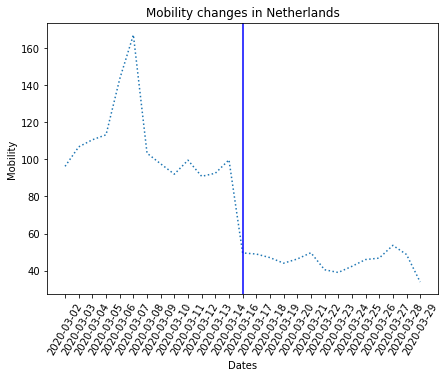

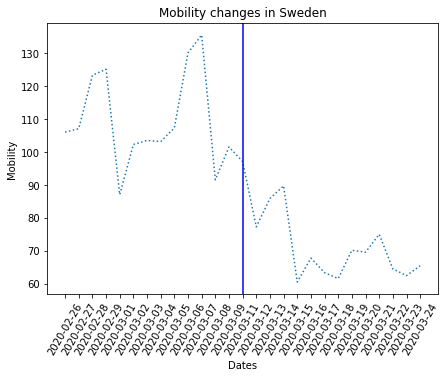

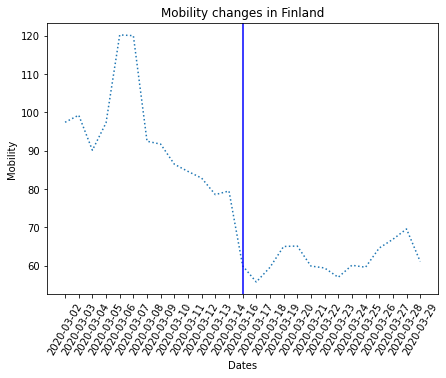

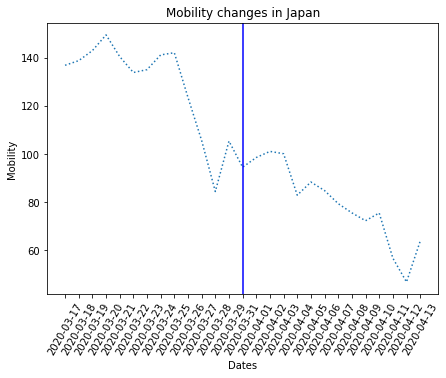

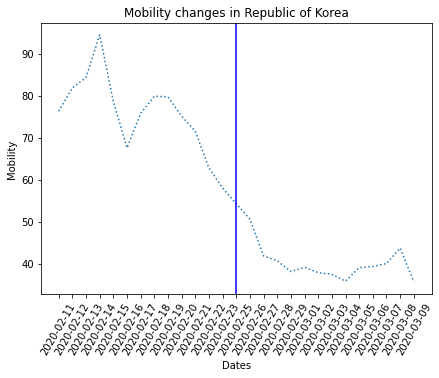

In [6]:
# plotting mobility changes in countries without lockdown
checkLockdown('nl', 'Netherlands')
checkLockdown('sv', 'Sweden')
checkLockdown('fi', 'Finland')
checkLockdown('ja', 'Japan')
checkLockdown('ko', 'Republic of Korea')

Let us define period in which we use to conduct our analysis.

In [7]:
# Defining period of interest for each country. Dates refered to 3 weeks before the first lockdown
lockdown_dates =  [interventions.loc[lang, 'Lockdown'] if not pd.isnull(interventions.loc[lang,'Lockdown']) else 
                  interventions.loc[lang,'Mobility'] for lang in languages]

period_per_countries = {}
for idx,country in enumerate(countries):
    lang = languages[idx]
    dates = [datetime.strptime(date.split()[0], '%Y-%m-%d')  for date in list(pagelogs_time_series[lang]['sum'].keys())]
    dates = [date for date in dates if (lockdown_dates[idx] - date < timedelta(21)) and 
             (lockdown_dates[idx] - date >  timedelta(0))]
    period_per_countries[country] = dates
    
# e.g. three weeks before lockdown in Serbia, Italy, Germany and Japan
print('Serbia',period_per_countries['RS'][0],'-',period_per_countries['RS'][-1])
print('Italy',period_per_countries['IT'][0],'-',period_per_countries['IT'][-1])
print('Germany',period_per_countries['DE'][0],'-',period_per_countries['DE'][-1])
print('Japan',period_per_countries['JA'][0],'-',period_per_countries['JA'][-1])

Serbia 2020-03-01 00:00:00 - 2020-03-20 00:00:00
Italy 2020-02-20 00:00:00 - 2020-03-10 00:00:00
Germany 2020-03-02 00:00:00 - 2020-03-21 00:00:00
Japan 2020-03-11 00:00:00 - 2020-03-30 00:00:00


<br/>
After creating the datasets (done in advance dealing with Twitter API rate limit), we import them to analyze the topics contained in tweeets. Notice that all tweets from different countries have been merged in a single file, which is the one we are going to use in the following cell.

In [8]:
# this dataframe is created by calling function 'getTweets' from helpers.py
influential_people_tweets = pd.read_csv('./output/influential_people_tweets.csv')
influential_people_tweets.head()

,id,country_code,lang,user,tweet_text_orginal,tweet_text_en,tweet_date,context_annotations
0,1234249601517047814,RS,sr,Response(data=<User id=356450858 name=Александ...,Хвала @AIPAC на изузетној части да говорим на ...,thanks on an exceptional honor to speak at the...,2020-03-01 22:50:10+00:00,"[{'domain': {'id': '45', 'name': 'Brand Vertic..."
1,1234183480625553410,RS,sr,Response(data=<User id=205153283 name=Dragan D...,"Ovakvih snimaka, kao ni onih kada ih izbacuju ...",several recordings like no ones when they thro...,2020-03-01 18:27:26+00:00,[]
2,1234196504123969536,RS,sr,Response(data=<User id=834073582514888710 name...,"Da li stel primetili suptilnu, ali vrlo podmuk...",did stel noticed a subtle but very insidious s...,2020-03-01 19:19:11+00:00,[]
3,1234253894244536323,RS,sr,Response(data=<User id=181338564 name=Marija S...,Safe trip girls🎉 #Hurricane,safe trip girls #hurricane,2020-03-01 23:07:14+00:00,[]
4,1234252303810600961,RS,sr,Response(data=<User id=181338564 name=Marija S...,Jebote jel su ljudi zaboravili da se raduju ????,fuck did people forget that they are looking f...,2020-03-01 23:00:55+00:00,[]


In [9]:
influential_people_tweets.shape

(31057, 8)

<br/>
For each country we would like to recognize to which topics tweets are related, what are the most common used words in tweets and to check sentyment of the tweets. All of this can be useful to understand the way communication has changed during the pandemic and how it impacted people.


In [10]:
# Libray to infer the topics discussed in each tweet
from empath import Empath
lexicon = Empath()


After reading the categories offered by empath library at https://github.com/Ejhfast/empath-client/blob/master/empath/data/categories.tsv, we report the ones we decide to use.

In [11]:
# Defining new categories using the most appropriate model
print('Covid \n')
_ = lexicon.create_category('covid',['flu','infection','virus','vaccine','death','social distance','hospital',
                                'fever','bat'], model ='nytimes')
print('\n')
print('Literacy \n')
_ = lexicon.create_category('literacy', ['book','literature','culture','essay','poetry','poem'], model='reddit')
print('\n')
print('Environment \n')
_ = lexicon.create_category('environment',['Earth','sky','sea','ocean','pollution','envirnonment',
                                     'global warming','rural',''],model = 'reddit')
print('\n')
print('Business & Economics \n')
_ = lexicon.create_category('business & economics',lexicon.cats['business'] + lexicon.cats['economics'],model='nytimes')
print('\n')
print('Transportation \n')
_ = lexicon.create_category('transportation',['mobility','air travel','car','walk','restriction',
                                         'lockdown','quarantine','isolation']+lexicon.cats['air_travel'][:5])
print('\n')

Covid 

["infection", "infections", "disease", "viral_infection", "virus", "meningitis", "ailment", "chicken_pox", "tumor", "fever", "chemotherapy", "lymph_nodes", "brain_damage", "antibiotics", "ulcers", "diarrhea", "tuberculosis", "hepatitis_C", "influenza", "lung", "colon_cancer", "rabies", "fevers", "transfusions", "inflammation", "transfusion", "flu", "measles", "Lyme_disease", "symptoms", "melanoma", "AIDS_virus", "malaria", "blood_transfusion", "bacterial_infection", "chest_pain", "arthritis", "heart_attacks", "tumors", "anemia", "colds", "polio", "heart_problems", "syphilis", "clot", "injections", "asthma", "chickenpox", "diagnosis", "hepatitis", "chronic_pain", "bone_marrow", "blood_transfusions", "biopsy", "encephalitis", "dementia", "multiple_sclerosis", "cancer", "epilepsy", "anesthesia", "dehydration", "polyps", "other_ailments", "fatal_disease", "parasite", "food_poisoning", "high_blood_pressure", "bone_marrow_transplant", "illness", "transplant", "recurrence", "human_imm

In [12]:
# Defining a list containing Twitter topics
topics = ['covid','literacy','government','environment','health','technology','cooking','business & economics',
         'transportation','sports','fun']

emotions = ["suffering", "optimism", "fear", "sadness", "joy", "anger", "pain", "negative_emotion", 
            "positive_emotion", "happiness"]

Using Empath library we want to check to which topics tweets from the analysed period are mostly related. We will plot the results for all the analysed countries. Please notice that, if compared to the plots shown in our website, the order of certain topics might slightly change because of how our new categories are created by Empath library (Taxonomy induction).

In [13]:
# function for plotting topic discussed in tweets
def plotTweetsTopics(country_code, country_name, topics, influential_people_tweets,ax):
    """
    Function which plots topic discussed in tweets
    
    Arguments:
        country_code: code of country from which we are retrieving tweets
        country_name: name of country from which we are retrieving tweets
        topics: list of topics
        influential_people_tweets: dataframe with tweets
    """
    colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']
    
    palette = {topic:color for topic,color in zip(topics,colors)}
    
    # We infer the topics discussed in the retrieved tweets
    tweets_from_country = influential_people_tweets.loc[influential_people_tweets['country_code']==country_code, 
                                                        'tweet_text_en']
     # plot only if we have some data from country
    if len(tweets_from_country) > 0:
        classified_topics = pd.DataFrame([lexicon.analyze(tweets_from_country.str.cat(sep=' '),
                                                      categories=topics, 
                                                      normalize=True)], index=[country_code]).T

        classified_topics = classified_topics.sort_values(by=[country_code], ascending=False)
        classified_topics.reset_index(inplace=True)

        sns.barplot(data=classified_topics, x=country_code, y='index', ax=ax, palette=palette)

        ax.set_xlabel('Normalized Score')
        ax.set_ylabel('', fontsize=14)
        ax.set_title('Topics discussed in ' + country_name)

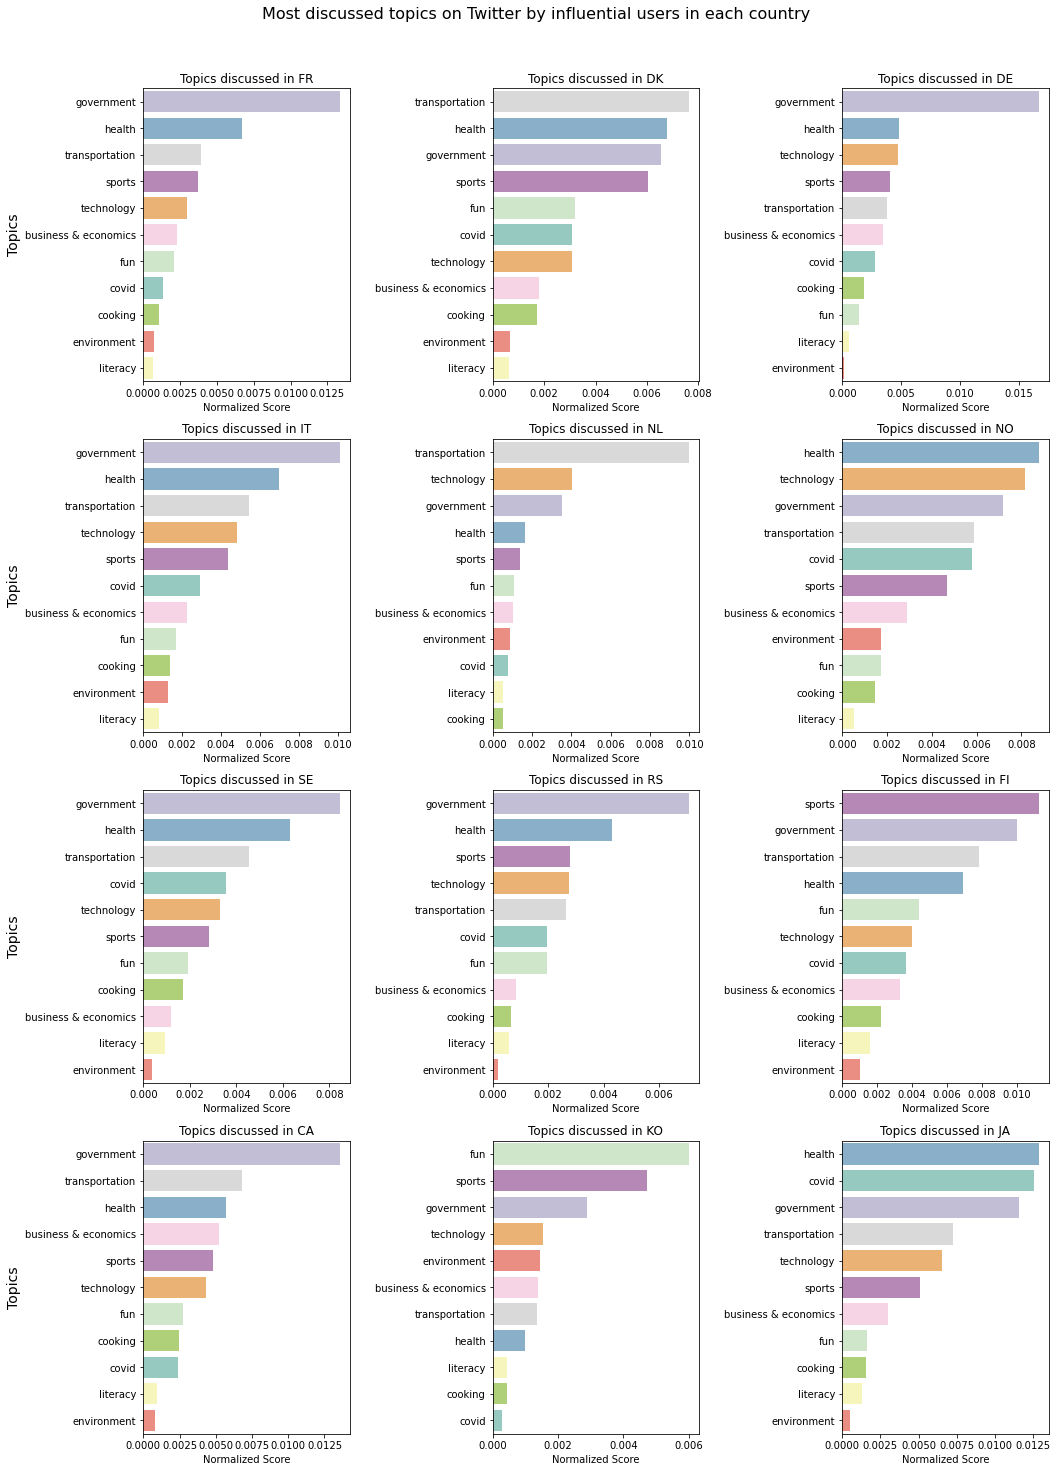

In [14]:
# Plotting topics discussed by influential people in all the analysed countries
fig, axs = plt.subplots(4,3, figsize=(15,20))

for country in countries:
    rows = ['Topics']*4
    index = countries.index(country)
    row = index // 3
    col = index % 3
    plotTweetsTopics(country, country, topics, influential_people_tweets, ax=axs[row,col])
    for ax,row in zip(axs[:,0],rows):
        ax.set_ylabel(row,fontsize=14)

fig.suptitle('Most discussed topics on Twitter by influential users in each country', fontsize=16, y=1.02)
fig.tight_layout()

From the plots above we can observe following:

- Italy is a country where influential people deeply cared to express their thoughts and opinions about the COVID-19. This is understandable, since Italy was in an extremely difficult situation during the early stage of the pandemic. A similar trend of discussed topics can be seen in Germany, France, Canada, and Serbia. The Netherlands showed less interest in covid and health-related topics, but transportation topic which can be a sign of mobility discussion is very prominent.

- Influential people from northern countries (Norway, Sweden, Denmark, and Finland) have a great interest in topics related to government, transportation, and health. But sports and technology are still substantial parts of discussed topics.

- In Korea the vast majority of influential people are related to entertainment, which perfectly reflects the most discussed topics. People from Korea, definitely couldn't read a lot of about COVID-19 on the Twitter. Finally, in Japan, COVID-19 is a largely discussed topic. 

<br/>

We now want to see which are the most important emotions detected in the tweets from each country. This is part of our sentiment analysis and it might reveal interesting insights about the population's behaviour and the situation of each country.
FOr what regards the methodology, we use an approach similar to the prevous one, using emotions list instead of topics list.

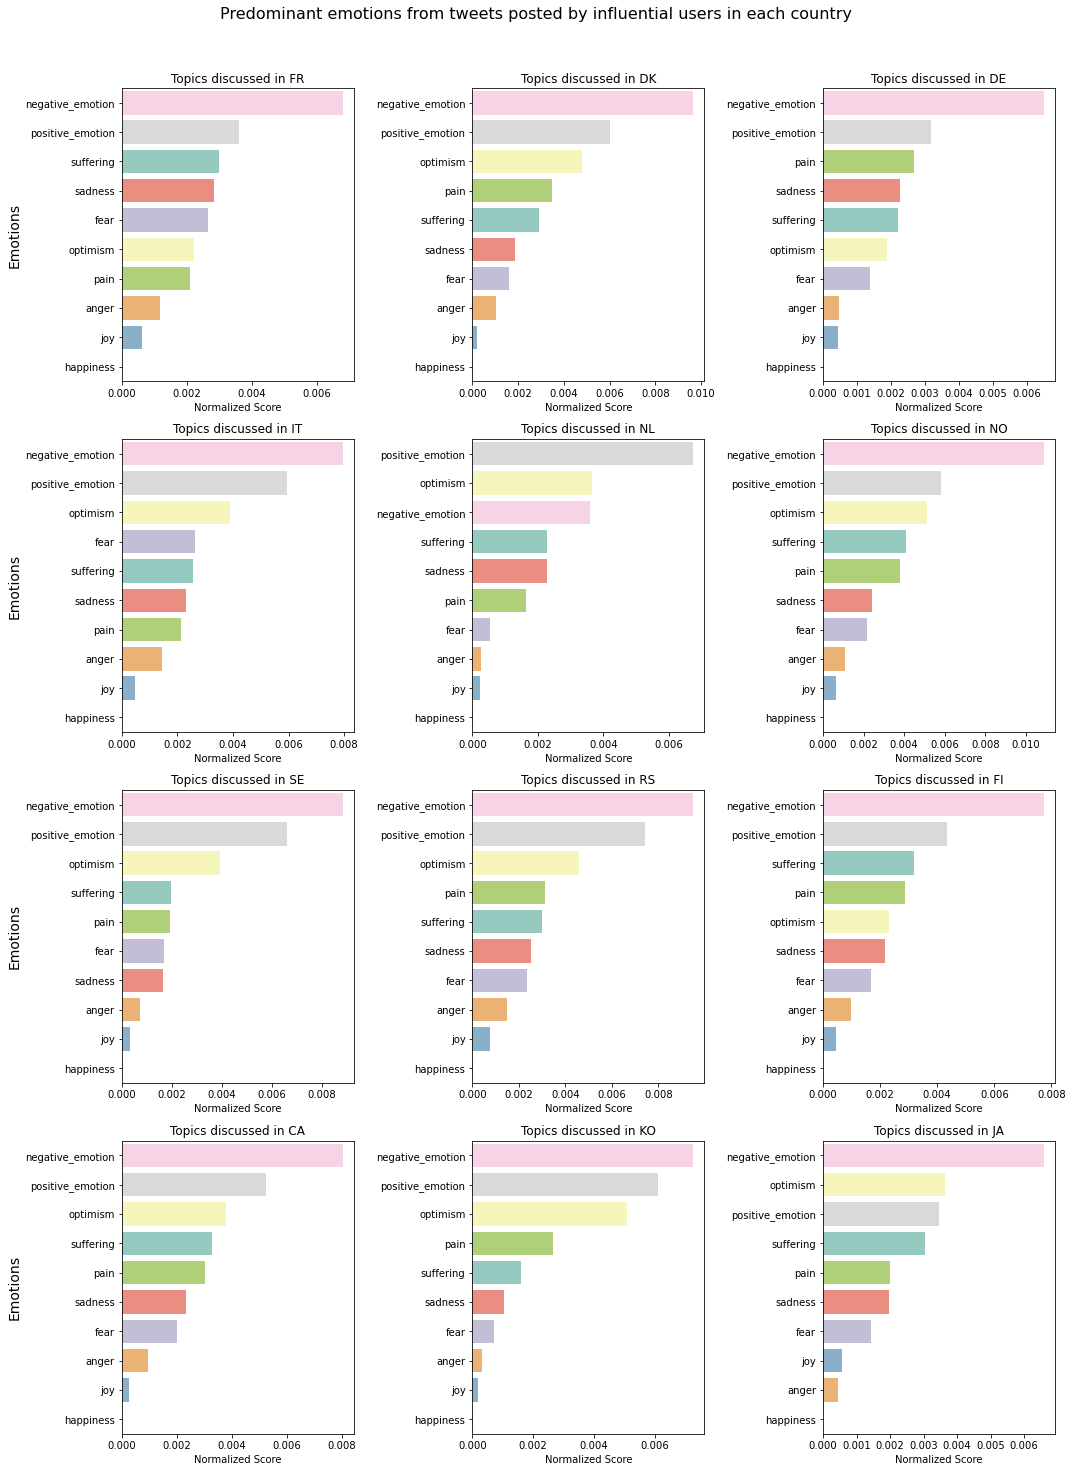

In [15]:
# Plotting dominating emotions in tweets in the analysed countries during 3 weeks preceding the lockdown
fig, axs = plt.subplots(4,3, figsize=(15,20))

for country in countries:
    rows = ['Emotions']*4
    index = countries.index(country)
    row = index // 3
    col = index % 3
    plotTweetsTopics(country, country, emotions, influential_people_tweets, ax=axs[row,col])
    for ax,row in zip(axs[:,0],rows):
        ax.set_ylabel(row,fontsize=14)

fig.suptitle('Predominant emotions from tweets posted by influential users in each country', fontsize=16, y=1.02)
fig.tight_layout()


From the plots above we can notice:
- Negative emotions are dominant in each country except in the Netherlands
- The Netherlands is country which didn't have lockdown. Even that they discussed transportation/mobility probably it was focused on positive side, and overcoming situation without most difficult measure - the lockdown. 
-  Even though negative emotions are in the first place, just after them we can notice positive emotions, which probably means that influential people tried both to warn people, but also to cheer them up and give the hope.
- Similarly, on one side we can observe optimist, but also on the other hand fear, suffering, and pain. And we can agree that all these emotions perfectly explain the pandemic situation.

As next step in our analysis, we want to find most used words in tweets in different countries.

In [16]:
from collections import Counter

def plotMostCommonWords(country_code, country_name, influential_people_tweets, ax):
    """
    Function which plot most common words in tweets of country
    
    Arguments:
        country_code: code of country from which we are retrieving tweets
        country_name: name of country from which we are retrieving tweets
        influential_people_tweets: dataframe with tweets
    Returns:
        most_common_words: list of most common words in tweeets
        all_words: all words from the tweets
    """
    
    # spliting text on words removing stop words, and looking only to nouns and verbs
    lemmatizer = WordNetLemmatizer()
    tweets_from_country = influential_people_tweets.loc[influential_people_tweets['country_code']==country_code, 
                                                        'tweet_text_en']
    all_words = ("".join(tweets_from_country.str.cat(sep=' '))).split()
    all_words = [lemmatizer.lemmatize(term) for term in all_words 
                 if (term not in stopwords.words('english')) and 
                 (nltk.pos_tag([term])[0][1] == 'NN' or nltk.pos_tag([term])[0][1] == 'VB')]

    # ten most common words
    most_common_words = Counter(all_words).most_common(10)

    words = list(dict(most_common_words).keys())
    counts = list(dict(most_common_words).values())
    
    colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']
    
    ax.set_xlabel('Most used words', fontsize=12)
    ax.set_xticklabels(ax.get_xticks(), rotation=90)
    ax.set_ylabel('', fontsize=12)
    ax.set_title('Most used words in influencing people tweets from '+ country_name)
    ax.bar(range(len(words)), counts, tick_label=words, color=colors)
    
    return most_common_words, all_words

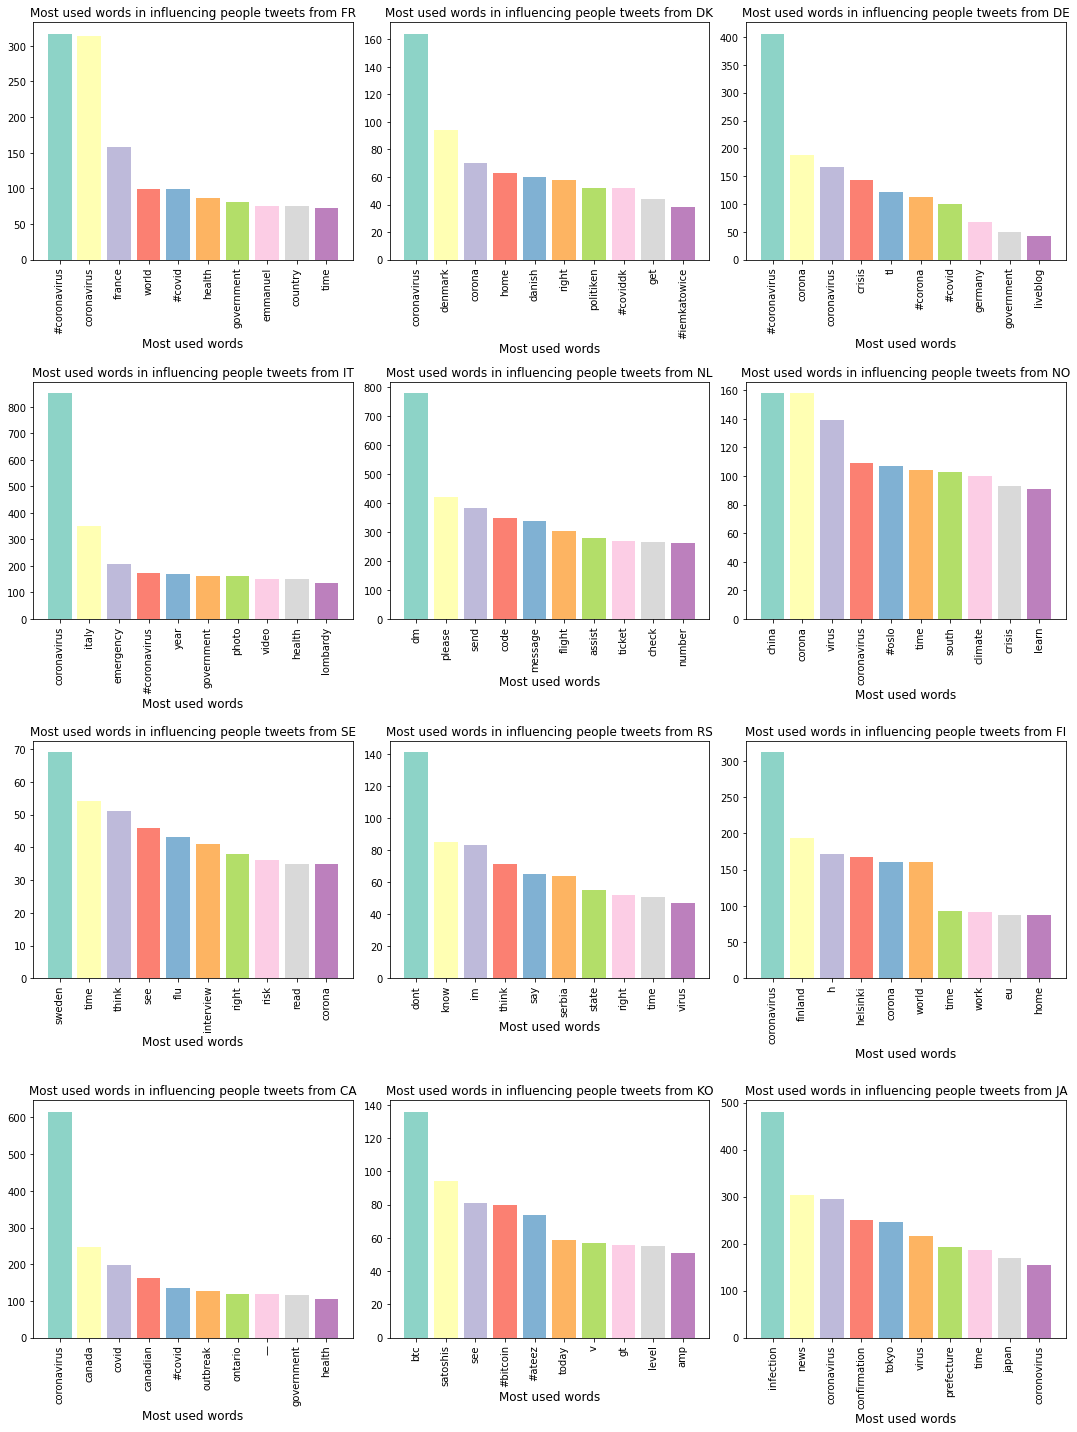

In [17]:
# Plotting most common words from tweets posted by influential people in analysed countries
most_common_words = {}
all_words = {}
# Plotting most common wo
fig, axs = plt.subplots(4,3, figsize=(15,20))
for country in countries:
    rows = ['Counts']*4
    index = countries.index(country)
    row = index // 3
    col = index % 3
    most_common, words = plotMostCommonWords(country, country, influential_people_tweets, ax=axs[row,col])
    most_common_words[country] = most_common
    all_words[country] = words
plt.tight_layout()

Most used words in tweets confirmed us a previous topics analysis:
- The main takeaway from this section is that tweets about frequently include terms like "corona", "coronavirus",  "emergency", "health" etc.
- As was to be expected given that the situation with covid varied by country, the most frequently used words in Korea and a few other countries do not refer to COVID-19.

Similarly, let us find most used hashtags in tweets in different countries.

In [18]:
def plotMostCommonHashtags(country_name, all_words, ax):
    """
    Function which plot most common hashtags in tweets of country
    
    Arguments:
        country_code: code of country from which we are retrieving tweets
        country_name: name of country from which we are retrieving tweets
        influential_people_tweets: dataframe with tweets
    Returns:
        most_common_hashtags: list of most common words in tweeets
    """
    #finding most common hashtags
    hashtags = [word for word in all_words if ('#' in word)]
    most_common_hashtags = Counter(hashtags).most_common(10)

    hashtags = list(dict(most_common_hashtags).keys())
    counts = list(dict(most_common_hashtags).values())

    colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']
    
    ax.set_xlabel('Most used hashtags', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticklabels(ax.get_xticks(), rotation = 90)
    
    ax.set_title('Most used hashtags in ' + country_name)
    ax.bar(range(len(hashtags)), counts, tick_label=hashtags, color=colors)
    
    return most_common_hashtags

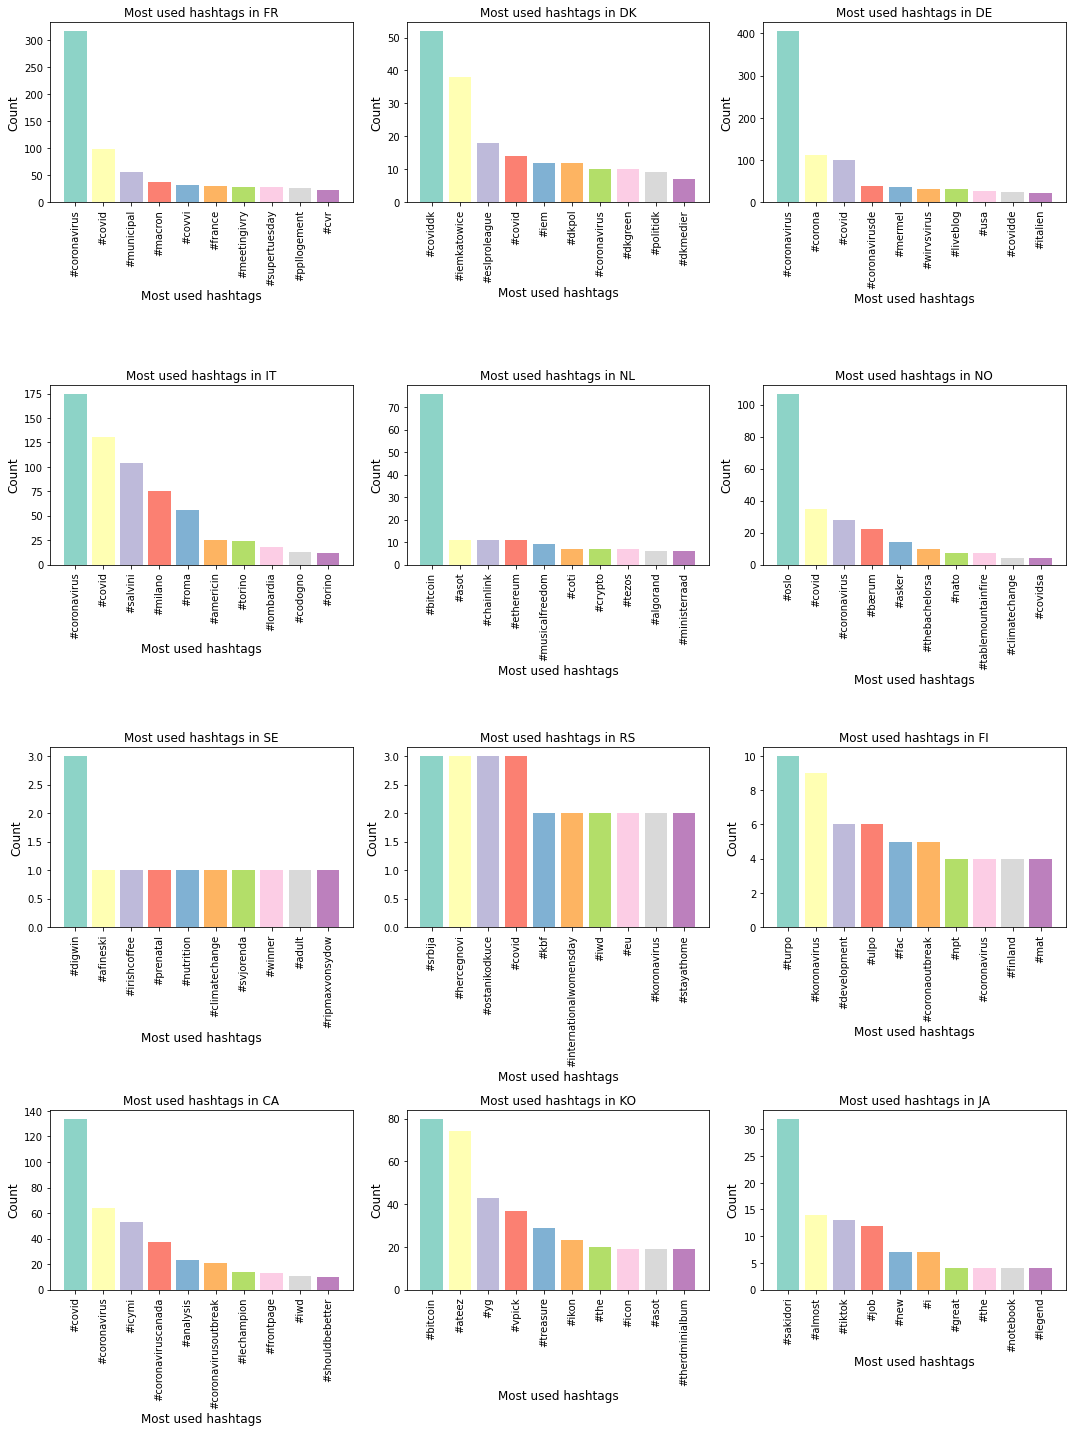

In [19]:
# plotting most common hashtags in tweets
most_common_hashtags = {}
fig, axs = plt.subplots(4,3, figsize=(15,20))
for country in countries:
    rows = ['Counts']*4
    index = countries.index(country)
    row = index // 3
    col = index % 3
    hashtags = plotMostCommonHashtags(country, all_words[country],ax=axs[row,col])
    most_common_hashtags[country] = hashtags
plt.tight_layout()

Since hashtags are sometime composed from multiple words, and it is difficult to translate it using some libraries, we are doing it manually and plotting again. The results obtained after the translation are in the following cell. 

In [20]:
# Defining a dictionary to contain all the translated hastags
# We only keep meaningful and important hastags
most_common_hastags = {}

# Politics + COVID-19
most_common_hastags['FR'] = [('#coronavirus', 317),
 ('#covid', 99),
 ('#municipal', 55),
 ('#macron', 37),
 ('#france', 29),
 ('#meetingivry', 28),
 ('#supertuesday', 28),
 ('#ppllogement', 26),
 ('#cvr', 23)]

# COVID-19 + environment
most_common_hashtags['DK'] = [('#coviddk', 52),
 ('#katowice', 38),
 ('#eslproleague', 18),
 ('#covid', 14),
 ('#coronavirus', 10),
 ('#dkgreen', 10),
 ('#politidk', 9)]

# COVID-19 + Italy (first country to have virus -> not true, it is not our fault :( )
most_common_hashtags['DE'] = [('#coronavirus', 406),
 ('#corona', 112),
 ('#covid', 100),
 ('#coronavirusde', 38),
 ('#usagainstvirus', 31),
 ('#liveblog', 30),
 ('#usa', 27),
 ('#covidde', 24),
 ('#italy', 22)]

# COVID-19 + politics (Salvini) + important cities
most_common_hashtags['IT'] = [('#coronavirus', 175),
 ('#covid', 130),
 ('#salvini', 104),
 ('#milano', 75),
 ('#roma', 56),
 ('#torino', 24),
 ('#lombardia', 18),
 ('#codogno', 13)] # place where there was the first case of COVID-19 in Italy

# Economy + trading -> no interest in virus, they did not even have lockdown
most_common_hashtags['NL'] = [('#bitcoin', 76),
 ('#asot', 11), # music festival
 ('#chainlink', 11), # related to blockchain
 ('#ethereum', 11),
 ('#musicalfreedom', 9),
 ('#crypto', 7),
 ('#tezos', 7), # related to crypto
 ('#algorithm', 6), 
 ('#cabinet', 6)]

# COVID-19 + environment
most_common_hashtags['NO'] = [('#oslo', 107),
 ('#covid', 35),
 ('#coronavirus', 28),
 ('#ashes', 14),
 ('#nato', 7),
 ('#tablemountainfire', 7),
 ('#climatechange', 4),
 ('#covidsa', 4)]

# Climate change 
most_common_hashtags['SE'] = [('#irishcoffee', 1),
 ('#prenatal', 1),
 ('#nutrition', 1),
 ('#climatechange', 1),
 ('#winner', 1),
 ('#adult', 1)]

# COVID-19
most_common_hashtags['RS'] = [('#stayathome', 5),
 ('#serbia', 3),
 ('#hercegnovi', 3),
 ('#covid', 3),
 ('#internationalwomensday', 2),
 ('#eu', 2),
 ('#coronavirus', 2)]

# Development + COVID-19
most_common_hashtags['FI'] = [('#coronavirus', 9),
 ('#development', 6),
 ('#coronaoutbreak', 5),
 ('#coronavirus', 4)]

# COVID-19 
most_common_hashtags['CA'] = [('#covid', 134),
 ('#coronavirus', 64),
 ('#icymi', 53), # in case you missed it
 ('#coronaviruscanada', 37),
 ('#analysis', 23),
 ('#coronavirusoutbreak', 21),
 ('#frontpage', 13),
 ('#iwd', 11), # International women's day
 ('#shouldbebetter', 10)]

# Entertainment (music celebrities and festival)
most_common_hashtags['KO'] = [('#bitcoin', 80),
 ('#ateez', 74), # music band (boy band)
 ('#yg', 43), # entertainment agency
 ('#icon', 42),                            
 ('#treasure', 29),
 ('#asot', 19)]

most_common_hashtags['JA'] = [('#sakidori', 32), # online shop
 ('#almost', 14),
 ('#tiktok', 13),
 ('#job', 12),
 ('#new', 7),
 ('#great', 4),
 ('#the', 4),
 ('#notebook', 4),
 ('#legend', 4)]

We now plot the most used hastags. These plots, together with the information collected in the previous cells, can offer interesting insights about the situation in every country.

In [21]:
from wordcloud import WordCloud

def imgHashtags(hashtags, country, ax):
    """
    Function which shows most common hashtags 
    
    Arguments:
        hashtags: dict of hashtags
    """
    wc = WordCloud(background_color='white').generate_from_frequencies(dict(hashtags))
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title('Most used hastags in '+country)
    ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    #ax.axis("off")

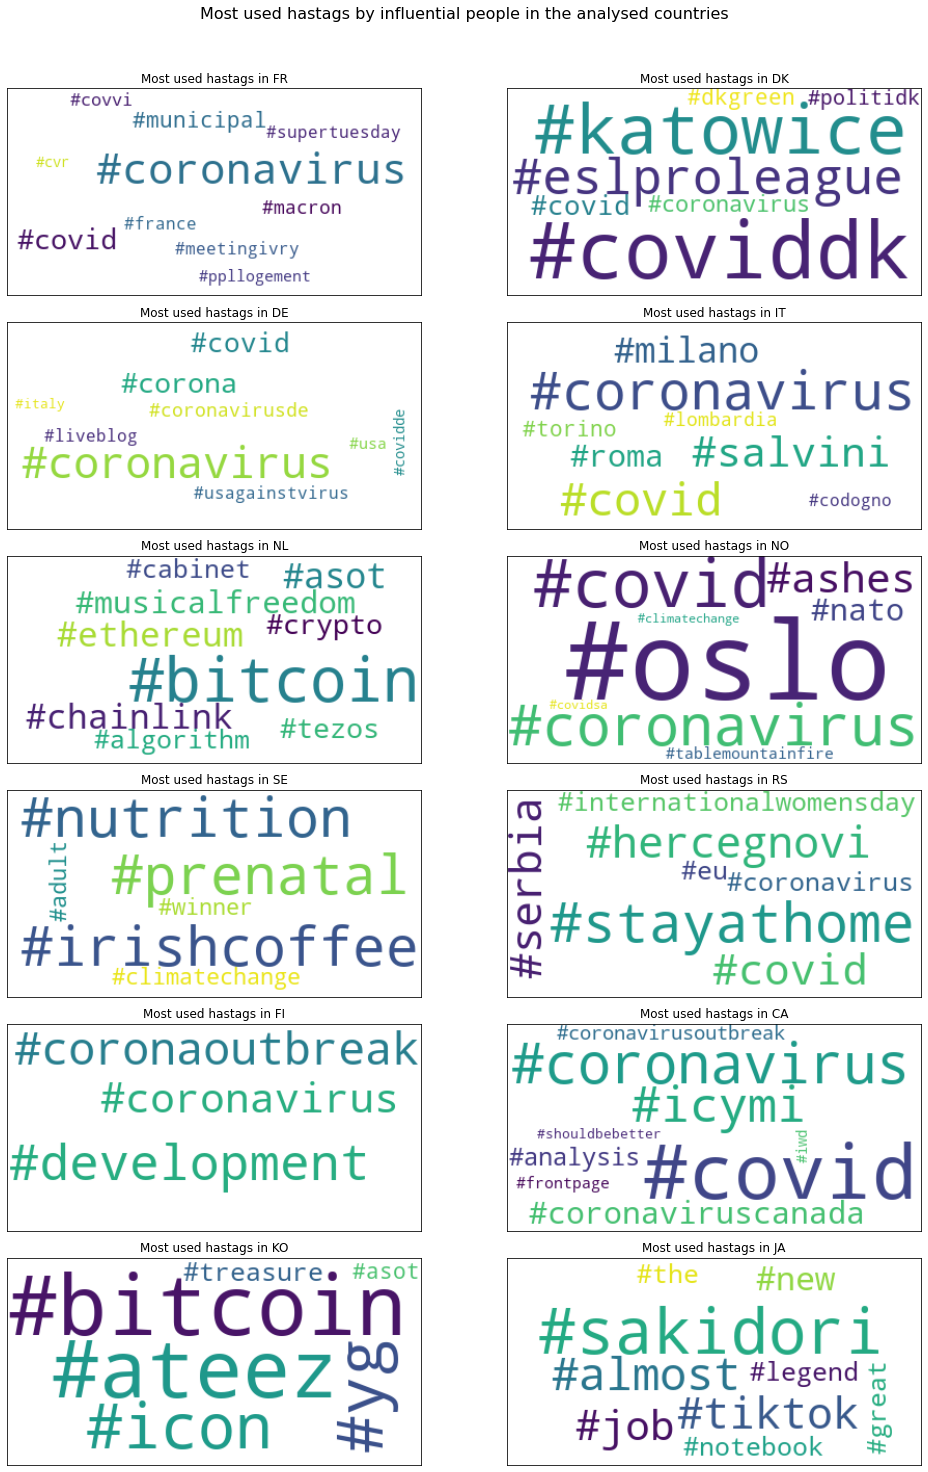

In [22]:
# Plotting hastags
fig, axs = plt.subplots(6,2, figsize=(15,20))
for country in countries:
    rows = ['Count']*6
    index = countries.index(country)
    row = index // 2
    col = index % 2
    hashtags = imgHashtags(most_common_hashtags[country], country, axs[row,col])

fig.suptitle('Most used hastags by influential people in the analysed countries', fontsize=16, y=1.02)
plt.tight_layout()

Once again, we have confirmation that covid was a big part of society during the analysis period. In a lot of countries, influential people used hashtags such as #covid #stayathome to try to inform and warn people about the pandemic situation. 

In some countries such as Japan and Sweden, even though covid-related topics are largely discussed, influential people didn't use hashtags a lot, which does not diminish the potential importance of those topics in those countries.

##### Conclusion & future steps

From the data we retrieved, we can conclude that in most of the countries influencial people started to spread a word about covid, and to warn population to #stayathome. Nevertheless, from all the plots we can observe noticable differences among coutries which is why we believe there is room for additional analysis that will give us our final conclusions.
